In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

In [65]:
df = pd.read_csv('./data/spaceship_titanic_fe_train_val.csv')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6938 non-null   float64
 1   RoomService                6938 non-null   float64
 2   FoodCourt                  6938 non-null   float64
 3   ShoppingMall               6938 non-null   float64
 4   Spa                        6938 non-null   float64
 5   VRDeck                     6938 non-null   float64
 6   Transported                6938 non-null   int64  
 7   PassengerIdInGroup         6938 non-null   int64  
 8   MembersOfGroupById         6938 non-null   float64
 9   MembersOfFamilyBySurname   6938 non-null   float64
 10  CabinNum_0_170             6938 non-null   float64
 11  CabinNum_170_430           6938 non-null   float64
 12  CabinNum_430_1000          6938 non-null   float64
 13  CabinNum_1000_             6938 non-null   float

In [67]:
simple_model = LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    random_state=42,
    silent=False,
    verbose= -100
)
features_names = [col for col in df.columns if col != 'Transported']
target_name = 'Transported'

## Permutation Importance

In [68]:
results_df = pd.DataFrame()
k_split = KFold(n_splits=5, shuffle=True, random_state=42)
for fold_num, (train_index, val_index) in enumerate(k_split.split(df)):
    train_df = df.loc[train_index]
    val_df = df.loc[val_index]
    
    X_train = train_df[features_names]
    y_train = train_df[target_name]
    
    X_val = val_df[features_names]
    y_val = val_df[target_name]
    
    simple_model.fit(X_train, y_train)
    
    r = permutation_importance(simple_model, X_val, y_val, n_repeats=30, random_state=42)
    results_df[f'mean_{fold_num}'] = r['importances_mean']
    results_df[f'std_{fold_num}'] = r['importances_std']
    
results_df['importances_mean'] = results_df[[f'mean_{fold_num}' for fold_num in range(5)]].mean(axis=1)
results_df['importances_std'] = results_df[[f'std_{fold_num}' for fold_num in range(5)]].mean(axis=1)
results_df.index = features_names
results_df = results_df.sort_values(by='importances_mean', ascending=False)

In [69]:
results_df['importances_mean']

CryoSleep_True               0.083386
Spa                          0.059711
VRDeck                       0.052494
RoomService                  0.040867
FoodCourt                    0.027150
CabinSide_S                  0.014985
ShoppingMall                 0.010287
CabinDeck_C                  0.008134
HomePlanet_Europa            0.007658
Destination_TRAPPIST-1e      0.006275
Age                          0.005108
CabinDeck_B                  0.004151
CabinDeck_E                  0.003363
CabinNum_170_430             0.002546
CabinDeck_F                  0.002013
CabinNum_0_170               0.001845
HomePlanet_Mars              0.001778
MembersOfFamilyBySurname     0.001725
PassengerIdInGroup           0.001494
CabinDeck_D                  0.001263
MembersOfGroupById           0.000869
CabinDeck_G                  0.000581
CabinNum_430_1000            0.000538
AgeBinned_Young              0.000538
VIP_True                     0.000341
CabinNum_1000_               0.000274
CabinDeck_Un

## Greedy feature selection

In [73]:
def greedy_feature_selection(X: pd.DataFrame, y: pd.Series, initial_features: list, max_features=float('inf'), patience=1):
    selected_features = [ft for ft in initial_features]
    remaining_features = [f for f in X.columns if f not in selected_features]
    best_f1_score = 0.0
    patience_counter = 0
    
    scores_df = pd.DataFrame(columns=['iteration', 'feature', 'score'])
    iteration_counter = 0
    while remaining_features and len(selected_features) < max_features:
        scores = {}
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            f1 = np.mean(cross_val_score(simple_model, X[trial_features], y, cv=5, scoring=make_scorer(f1_score)))
            scores[feature] = f1

        best_feature, best_score = max(scores.items(), key=lambda x: x[1])

        if best_score > best_f1_score:
            patience_counter = 0
            print(f"Adding feature: {best_feature} with F1 score: {best_score}")
            best_f1_score = best_score
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Reached patience threshold. Terminating.")
                break
            else:
                print(f"Added feature: {best_feature} with F1 score: {best_score} with patience {patience_counter}/{patience}")
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
        
        scores_df.loc[iteration_counter] = [iteration_counter, best_feature, best_score]
        scores_df = scores_df.reset_index(drop=True)
        iteration_counter += 1
    return scores_df


selected_features = greedy_feature_selection(df[features_names], df[target_name], [], patience=3)
selected_features

Adding feature: RoomService with F1 score: 0.7107654523722857
Adding feature: Spa with F1 score: 0.7460431223147885
Adding feature: VRDeck with F1 score: 0.7785041191214777
Adding feature: HomePlanet_Europa with F1 score: 0.7922758829089105
Adding feature: CabinDeck_C with F1 score: 0.7969028103536203
Adding feature: CabinNum_1000_ with F1 score: 0.7972244174457145
Adding feature: AgeBinned_Teenager with F1 score: 0.797476253351141
Added feature: CabinDeck_T with F1 score: 0.797476253351141 with patience 1/3
Added feature: FoodCourt with F1 score: 0.7971771900959 with patience 2/3
Adding feature: CabinSide_S with F1 score: 0.8006455833263516
Adding feature: CabinDeck_B with F1 score: 0.8039459280573851
Added feature: ShoppingMall with F1 score: 0.8032534601731666 with patience 1/3
Adding feature: CabinDeck_D with F1 score: 0.8056931201128549
Adding feature: CabinDeck_E with F1 score: 0.8060055238275124
Adding feature: Destination_TRAPPIST-1e with F1 score: 0.8070047425663146
Added feat

,iteration,feature,score
0,0,RoomService,0.710765
1,1,Spa,0.746043
2,2,VRDeck,0.778504
3,3,HomePlanet_Europa,0.792276
4,4,CabinDeck_C,0.796903
5,5,CabinNum_1000_,0.797224
6,6,AgeBinned_Teenager,0.797476
7,7,CabinDeck_T,0.797476
8,8,FoodCourt,0.797177
9,9,CabinSide_S,0.800646


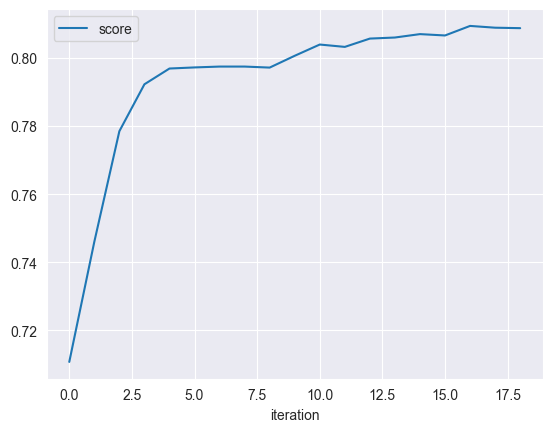

In [76]:
selected_features.plot(x='iteration', y='score')
plt.show()

## Cross comparison

In [83]:
selected_features

,iteration,feature,score
0,0,RoomService,0.710765
1,1,Spa,0.746043
2,2,VRDeck,0.778504
3,3,HomePlanet_Europa,0.792276
4,4,CabinDeck_C,0.796903
5,5,CabinNum_1000_,0.797224
6,6,AgeBinned_Teenager,0.797476
7,7,CabinDeck_T,0.797476
8,8,FoodCourt,0.797177
9,9,CabinSide_S,0.800646


In [89]:
data = []
for col in selected_features['feature'].tolist():
    if col in results_df.index:
        permutation_rank = results_df.index.get_loc(col) + 1
        greedy_rank = selected_features[selected_features['feature'] == col]['iteration'].values[0] + 1
        data.append([col, permutation_rank, greedy_rank])
        
fts = pd.DataFrame(data, columns=['feature_name', 'permutation_rank', 'greedy_rank'])
fts['avg_rank'] = fts[['permutation_rank', 'greedy_rank']].mean(axis=1)
fts = fts.sort_values(by='avg_rank', ascending=True)
fts

,feature_name,permutation_rank,greedy_rank,avg_rank
1,Spa,2,2,2.0
0,RoomService,4,1,2.5
2,VRDeck,3,3,3.0
3,HomePlanet_Europa,9,4,6.5
4,CabinDeck_C,8,5,6.5
8,FoodCourt,5,9,7.0
9,CabinSide_S,6,10,8.0
11,ShoppingMall,7,12,9.5
10,CabinDeck_B,12,11,11.5
14,Destination_TRAPPIST-1e,10,15,12.5


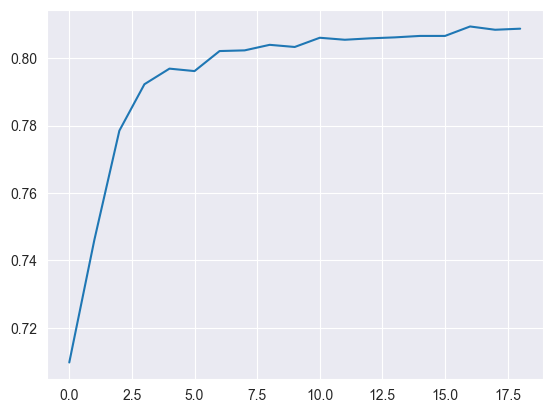

In [93]:
scores = []
added_features = []
for ft in fts['feature_name'].tolist():
    added_features.append(ft)
    X = df[added_features]
    y = df[target_name]
    
    f1 = np.mean(cross_val_score(simple_model, X, y, cv=5, scoring=make_scorer(f1_score)))
    scores.append(f1)
    
plt.plot([i for i in range(0, len(scores))], scores)
plt.show()

In [105]:
SELECTED_FEATURES = added_features[:17]
print('Score= ', scores[16])
print(SELECTED_FEATURES)

Score=  0.8094104697315183
['Spa', 'RoomService', 'VRDeck', 'HomePlanet_Europa', 'CabinDeck_C', 'FoodCourt', 'CabinSide_S', 'ShoppingMall', 'CabinDeck_B', 'Destination_TRAPPIST-1e', 'CabinDeck_E', 'CabinNum_1000_', 'CabinNum_0_170', 'CabinDeck_D', 'AgeBinned_Teenager', 'CabinDeck_T', 'AgeBinned_Elder']
